In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torch.optim as opt
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
from sklearn.cluster import KMeans

from torch.utils.checkpoint import checkpoint
#for loading data
import h5py
import torch.utils.data as tud

## Hyper parameters

In [0]:
# Batch size during training
batch_size = 64
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32
# Number of training epochs
num_epochs =50
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Learning rate for optimizers
lr = 0.00003

In [0]:
#check if GPU is working and set device
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

##loading and preprocessing data

In [0]:
## Image loading and processing: load data from HDF5 and normalize, then save as a tensor
transform=transforms.Compose([
                               transforms.ToPILImage(),
                               transforms.Resize(image_size),#
                               transforms.CenterCrop(image_size),#
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

class loadHDF5(tud.Dataset):
    '''
    this will output the [n,3,32,32] tensor without normalizing 
    '''
    def __init__(self, file_path,transform=None):
        super(loadHDF5, self).__init__()
        h5_file = h5py.File(file_path)
        self.data = h5_file.get('data')
        self.target = h5_file.get('label')
        self.transform = transform
        
    def __getitem__(self):   

        return torch.from_numpy((self.data[:,:,:,:])).float()


    def __len__(self):
        return self.data.shape[0]
      


ld5=loadHDF5('/content/drive/My Drive/Colab Notebooks/LLD_32/LLD-icon-sharp.hdf5')
img = ld5.__getitem__()


outputs=[]

for i,ch in enumerate(range(img.size(0)), 0):
    tensor = transform(img[ch,:,:,:])
    tensor = tensor.unsqueeze(0)
    outputs.append(tensor)
    
icons_32_32 = torch.cat(outputs, dim=0)

ld5=loadHDF5('/content/drive/My Drive/Colab Notebooks/LLD_32/LLD-icon.hdf5')
img = ld5.__getitem__()
outputs=[]    
    
for i,ch in enumerate(range(img.size(0)), 0):
    tensor = transform(img[ch,:,:,:])
    tensor = tensor.unsqueeze(0)
    outputs.append(tensor)
    
icons_32_32_1 = torch.cat(outputs, dim=0)

torch.save(icons_32_32, '/content/drive/My Drive/Colab Notebooks/LLD_32/icon_sharp.pt')
outputs = None
img = None
ld5 = None

In [0]:
#combine 2 datasets
icons_32_32_1 = None
icons_32_32 = None
icons_32_32_1=torch.load( '/content/drive/My Drive/Colab Notebooks/LLD_32/icon_32.pt')
icons_32_32=torch.load( '/content/drive/My Drive/Colab Notebooks/LLD_32/icon_sharp.pt')
icon_combined = torch.cat((icons_32_32_1,icons_32_32), dim=0)
icon_combined.shape
icons_32_32_1 = None
icons_32_32 = None

### =====================above is for loading dataset ========================

In [0]:
# wrap up the images in dataloader
LLDLoader = torch.utils.data.DataLoader(icon_combined, shuffle=True, batch_size=batch_size)


In [0]:
#plot 64(8*8) images in one plot
def showImages(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.cpu()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [0]:
#initialize weights 'CONV' and 'Batch' by normal distribution with(mean,std) 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0., 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1., 0.02)
        m.bias.data.fill_(0.)


##Autoencoder part

In [0]:
#hyper parameters for autoencoder 
#number of feature maps extract by autoencoder 
nf_auto = 4

#autoencoder to encode the input image for clustering 
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            #input 32x32
            nn.Conv2d(nc, nf_auto, 4, 2, 1), 
            nn.ReLU(True),
            #state size 16x16
            nn.Conv2d(nf_auto, nf_auto*2 , 4, 2, 1),  
            nn.ReLU(True),
            #state size 8x8
            nn.Conv2d(nf_auto*2, nf_auto*4 , 4, 2, 1),  
            nn.ReLU(True),
            #output 4*4
        )
        
        self.decoder = nn.Sequential(
            #input is 4x4
            nn.ConvTranspose2d(nf_auto*4, nf_auto*2, 4, 2, 1),  
            nn.ReLU(True),
            #state size 8x8
            nn.ConvTranspose2d(nf_auto*2, nf_auto, 4, 2, 1),  
            nn.ReLU(True),
            #state size 16x16
            nn.ConvTranspose2d(nf_auto, nc, 4, 2, 1),  
            nn.Tanh()
            #output 16x16
        )

    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode

In [0]:
#set parameters for autoencoder 
autoencoder = Autoencoder()
autoencoder.cuda()
criterion_auto = nn.MSELoss()
optimizer_auto = torch.optim.Adam(autoencoder.parameters(), lr=lr, betas=(beta1, 0.999))

In [0]:
#apply initial weights for autoencoder
autoencoder.apply(weights_init)

In [0]:
#apply saved weights for autoencoder 
Autoencoder_weights=torch.load('/content/drive/My Drive/Colab Notebooks/LLD_32/Autoencoder_weights_4')
autoencoder.load_state_dict(Autoencoder_weights['state_dict'])
optimizer_auto.load_state_dict(Autoencoder_weights['optimizer'])

In [0]:
#train autoencoder 
for epoch in range(num_epochs):
    for i, data in enumerate(LLDLoader, 0):
        img = data.to(device)
  
        # get the result from the decoder
        output = autoencoder(img)[1]
        #calculae the loss between original image and the decoder
        loss_auto = criterion_auto(output, img)
        #backpropogation
        optimizer_auto.zero_grad()
        loss_auto.backward()
        optimizer_auto.step()
        
        if i % 3450 == 0:
            print('[%d/%d][%d/%d]' % (epoch, num_epochs, i, len(LLDLoader)))
                     
        if i % 11000==0:
            print("original image: ")
            showImages(data[0:8][:][:][:])
            print("decoded image: ")
            decoded = output.detach()
            showImages(decoded[0:8][:][:][:])
            
            Autoencoder_weights = {
                'epoch': epoch,
                'state_dict': autoencoder.state_dict(),
                'optimizer': optimizer_auto.state_dict(),

            }
            torch.save(Autoencoder_weights, '/content/drive/My Drive/Colab Notebooks/LLD_32/Autoencoder_weights_4') 
            print("Saved weights successfully")

In [0]:
check_decoder = autoencoder(icon_combined[0:64].to(device))[1]
check_decoder.shape
showImages(check_decoder.detach())

###================= above is autoencoder part ====================

##Kmeans clustering 

In [0]:
torch.cuda.empty_cache()

In [0]:
check_encoder = autoencoder(icon_combined[0:50000].to(device))[0]
dim =check_encoder.shape
a=check_encoder.view(dim[0],dim[1]*dim[2]*dim[3])
a.shape

torch.Size([50000, 256])

In [0]:
b=a.detach().cpu().numpy()
b.shape

(50000, 256)

In [0]:
encoded = autoencoder(icon_combined.to(device))[0]
dim =encoded.shape
encoded=encoded.view(dim[0],dim[1]*dim[2]*dim[3])
encoded.shape

RuntimeError: ignored

In [0]:
encoded_np=encoded.detach().cpu().numpy()
b.shape

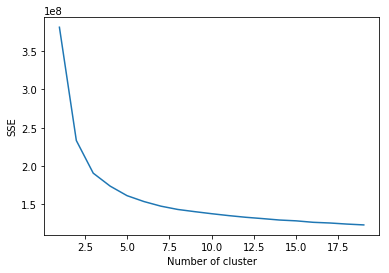

In [0]:
sse = {}
index = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, max_iter=10, random_state = 1234).fit(b)
    #b["clusters"] = kmeans.labels_

    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    index[k] = kmeans.labels_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

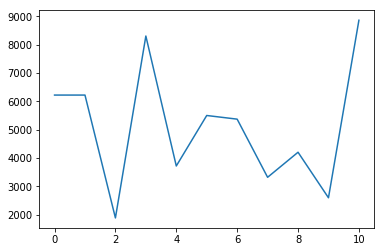

In [0]:
cluster_0 = icon_combined[np.where(index[10]==0)]
cluster_1 = icon_combined[np.where(index[10]==1)]
cluster_2 = icon_combined[np.where(index[10]==2)]
cluster_3 = icon_combined[np.where(index[10]==3)]
cluster_4 = icon_combined[np.where(index[10]==4)]
cluster_5 = icon_combined[np.where(index[10]==5)]
cluster_6 = icon_combined[np.where(index[10]==6)]
cluster_7 = icon_combined[np.where(index[10]==7)]
cluster_8 = icon_combined[np.where(index[10]==8)]
cluster_9 = icon_combined[np.where(index[10]==9)]
size_of_clusters = [cluster_0.shape[0],cluster_0.shape[0],cluster_1.shape[0],cluster_2.shape[0],\
                    cluster_3.shape[0],cluster_4.shape[0],cluster_5.shape[0],cluster_6.shape[0],\
                    cluster_7.shape[0],cluster_8.shape[0],cluster_9.shape[0]]
plt.plot(size_of_clusters)
plt.xlabel("Each cluster ")
plt.ylabel("Number of images")
plt.title("Number of images in each cluster")

In [0]:
cluster_0_Loader = torch.utils.data.DataLoader(cluster_0, shuffle=True, batch_size=batch_size)
cluster_1_Loader = torch.utils.data.DataLoader(cluster_1, shuffle=True, batch_size=batch_size)
cluster_2_Loader = torch.utils.data.DataLoader(cluster_2, shuffle=True, batch_size=batch_size)
cluster_3_Loader = torch.utils.data.DataLoader(cluster_3, shuffle=True, batch_size=batch_size)
cluster_4_Loader = torch.utils.data.DataLoader(cluster_4, shuffle=True, batch_size=batch_size)
cluster_5_Loader = torch.utils.data.DataLoader(cluster_5, shuffle=True, batch_size=batch_size)
cluster_6_Loader = torch.utils.data.DataLoader(cluster_6, shuffle=True, batch_size=batch_size)
cluster_7_Loader = torch.utils.data.DataLoader(cluster_7, shuffle=True, batch_size=batch_size)
cluster_8_Loader = torch.utils.data.DataLoader(cluster_8, shuffle=True, batch_size=batch_size)
cluster_9_Loader = torch.utils.data.DataLoader(cluster_9, shuffle=True, batch_size=batch_size)

### ================= above is Kmeans part =================

In [0]:
#generator
class generator(nn.Module):
    # initializers
    def __init__(self):
        super(generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False), 
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf * 1, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(ngf * 1),
            nn.ReLU(True),
            # state size. (ngf*1) x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False), 
            nn.Tanh()
            # state size. (nc) x 32 x 32
            )
        
            # forward method
    def forward(self, input):

        return self.main(input)

In [0]:
#discriminator
   
class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),  
            nn.Sigmoid()
        )

            # forward method
    def forward(self, input):
        return self.main(input)

In [0]:
#save the model
G=generator()
D=discriminator()

#set the loss function
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1).to(device) 

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = opt.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = opt.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

#just for tracing the performance of model
img_list = []
G_losses = []
D_losses = []


In [0]:
# set model to GPU
D.cuda()
G.cuda()


In [0]:
#apply initialize weights
#G.apply(weights_init)
#D.apply(weights_init)


In [0]:
#apply saved weights
stateG_icon32x32=torch.load('/content/drive/My Drive/Colab Notebooks/LLD_32/G_icon_new')
G.load_state_dict(stateG_icon32x32['state_dict'])
optimizerG.load_state_dict(stateG_icon32x32['optimizer'])

stateD_icon32x32=torch.load('/content/drive/My Drive/Colab Notebooks/LLD_32/D_icon_new')
D.load_state_dict(stateD_icon32x32['state_dict'])
optimizerD.load_state_dict(stateD_icon32x32['optimizer'])

In [0]:
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(LLDLoader, 0):
#        X, _ = data #just for debugging
        '''
        ###########################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ### Train with all-real batch
        '''
        # Firstly, have to set grad to zero
        D.zero_grad()
        ## Format batch
        #different from MNIST, our data structure do not have label 
        real_img = data.to(device) 
        # Set the batch size same as the image batch size we input every time
        #sometimes it would not be same as the setting at original e.g.64, 60000/64 will left 32)
        b_size = real_img.size(0)
        # Create the label for images from true dataset   
        one_label = torch.full((b_size,), real_label).to(device)  
        # Forward pass real batch through D
        output = D(real_img).view(-1).to(device) 
        # Calculate loss on all-real batch
        errD_real = criterion(output, one_label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        
        '''
        ###################################
        ## Train D with all-fake batch
        ###################################
        '''                

        # Generate batch of latent vectors(100-vector)
        noise = torch.randn(b_size, nz, 1, 1).to(device) 
        # Generate fake image batch with G
        fake = G(noise)

        zero_label = torch.full((b_size,), fake_label).to(device) 
        # Classify all fake batch with D
        output = D(fake.detach()).view(-1).to(device) 
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, zero_label)
        # Calculate the gradients for this batch
        errD_fake.backward()
     
        ########### for statistics ############
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        #######################################
        
        # Update D
        optimizerD.step()
        '''
        ###########################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        '''
        G.zero_grad()

        # Since we just updated D, perform another forward pass of all-fake batch through D

        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, one_label)
        # Calculate gradients for G
        errG.backward()
        
        ########### for statistics ############
        D_G_z2 = output.mean().item()
        #######################################
        
        # Update G
        optimizerG.step()
        
        
        if i % 3450 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(LLDLoader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        
        
        if i % 11000==0:
            #samples = fake.detach()
            #samples = samples.view(samples.size(0), 3, 32, 32)
            #showImages(samples)

            stateG_icon32x32 = {
                'epoch': epoch,
                'state_dict': G.state_dict(),
                'optimizer': optimizerG.state_dict(),

            }
            torch.save(stateG_icon32x32, '/content/drive/My Drive/Colab Notebooks/LLD_32/G_icon_new')
            
            stateD_icon32x32 = {
                'epoch': epoch,
                'state_dict': D.state_dict(),
                'optimizer': optimizerD.state_dict(),

            }
            torch.save(stateD_icon32x32, '/content/drive/My Drive/Colab Notebooks/LLD_32/D_icon_new')

In [0]:
i, epoch


In [0]:
#manully plot
b_size=64
noise = torch.randn(b_size, nz, 1, 1).to(device) 
# Generate fake image batch with G
fake = G(noise)
samples = fake.detach()
samples = samples.view(samples.size(0), 3, 32, 32)
showImages(samples)

In [0]:
#save weight manually

stateG_icon32x32 = {
    'epoch': epoch,
    'state_dict': G.state_dict(),
    'optimizer': optimizerG.state_dict(),

}
torch.save(stateG_icon32x32, '/content/drive/My Drive/Colab Notebooks/LLD_32/G_icon_new') 
stateD_icon32x32 = {
    'epoch': epoch,
    'state_dict': D.state_dict(),
    'optimizer': optimizerD.state_dict(),

}
torch.save(stateD_icon32x32, '/content/drive/My Drive/Colab Notebooks/LLD_32/D_icon_new')

print("saved successfully")